In [1]:
# ===== Baseline possession-xG modeling =====
import numpy as np
import pandas as pd

from mplsoccer import Pitch
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap, ScalarMappable


from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, average_precision_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import TweedieRegressor

events = pd.read_csv("events_compact.csv")
poss = pd.read_csv("possessions.csv")

print(events.columns)


Index(['match_id', 'possession', 'team_id', 'player_id', 'type', 'x', 'y',
       'end_x', 'end_y', 'minute', 'second', 'index', 'shot_statsbomb_xg',
       'shot_outcome', 'pass_length', 'pass_outcome'],
      dtype='object')


WHAT WE ARE MODELLING
Objective: Predict the expected goals produced by a possession

    change in y = possession_xG = Change in xG of shots in that possession

This is a *regression* on a [non-negative], very skewed target (most possessions have 0.0, a few have 0.1 - 0.6)
    We'll start with possession-level features (post-hoc). Later you can evolve to in-possession, step by step predictions

Why these models: 
- HistGradientBoostingRegressor (HGBR): Tree-based, handles nonlinearity, interactions, and missing values well; fast on big data
- TweedieRegressor (GLM): Linear model for non-negative targets with many zeros (Tweedie power 1 < p < 2); gives a strong, interpretable baseline

*Splitting Correctly*: Use GroupKFold by match_id so events/possessions from teh same match never leak across train/validation

Metrics to WatchL
- MAE / RMSE / R^2 for regression quality
- Calibration (bin predictions and compare to actual mean xG ber pin)
- Optional classification view: pick a high - xG threshold like 0.15 and check precision/recall/AUC using (change in y)y >= tau (as the classifier)

*Imbalance*: Target has many zeros, That's fine for baseline; if you want to weight [dangerous] possessions more, add a simple sample weight (2x for y >= 0.15). Try unweighted first

Features (baseline) from poss table: 
- Counts
- Geometry/progression
- Start/End
- Timing
- Do not include identifiers


In [2]:
df = poss.copy()

feature_cols = [c for c in [
    "n_events", "n_shots","prog_dist","net_prog",
    "start_x","start_y","end_x","end_y","duration_s"
] if c in df.columns]

target_col = "possession_xg"
group_col = "match_id"

X = df[feature_cols]
Y = df[target_col].astype("float32").values
groups = df[group_col].values

print(f"Features: {feature_cols}")
print("X shape:", X.shape, " y shape:", Y.shape, " matches:", np.unique(groups).size)

# 1 PREPROCESSORS
# - FOR TREE MODEL: SIMPLE IMPUTE MISSING NUMERICS WITH MEDIAN
# - FOR GLM: IMPUTE + SCALE (GLMS ARE SENSITIVE TO FEATURE SCALE)
num_imputer = SimpleImputer(strategy = "median")

pre_tree = ColumnTransformer([
    ("num", num_imputer, feature_cols)
], remainder='drop')

pre_glm = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc",StandardScaler())]), feature_cols)
], remainder='drop')

# 2 MODELS
tree = HistGradientBoostingRegressor(
    loss = "squared_error",
    max_depth=None,
    learning_rate=0.08,
    max_bins=225,
    max_iter=300,
    l2_regularization=0.0,
    random_state=42
)

glm = TweedieRegressor(
    power = 1.5, # 1 < p < 2 gives zero mass + continuous positive support
    alpha = 0.0005, # L2 regularization
    link = "log", # Positive predictions
    max_iter = 1000
)

pipe_tree = Pipeline([("pre",pre_tree), ("model", tree)])
pipe_glm = Pipeline([("pre", pre_glm), ("model", glm)])

# 3 GroupKFold CV Evluation
gkf = GroupKFold(n_splits=5)

def eval_model(pipe, X, Y, groups, tau =0.15, sample_weights = None):
    maes, rmses, r2s = [], [], []
    ap_scores, aucs = [], []
    oof_pred = np.zeros_like(Y, dtype=float)

    for fold, (tr, va) in enumerate(gkf.split(X, Y, groups), 1):
        Xtrain, Xva = X.iloc[tr], X.iloc[va]
        Ytr, Yva = Y[tr], Y[va]
        wtr = None if sample_weights is None else sample_weights[tr]

        pipe.fit(Xtrain, Ytr, **({"model__sample_weight": wtr} if wtr is not None else {}))
        pred = pipe.predict(Xva)
        oof_pred[va] = pred

        mae = mean_absolute_error(Yva, pred)
        rmse = np.sqrt(mean_squared_error(Yva, pred))  
        r2 = r2_score(Yva, pred)

        # CLASSIFICATION VIEW FROM REGRESSION: PREDICT HIGH xG VIA THRESHOLD
        Yva_bin = (Yva >= tau).astype(int)
        pred_bin = (pred >= tau).astype(int)

        # AVERAGE PRECISION (REQUIRES CONTINUOUS SCORES); ROC AUC MAY BE UNDEFINED IF ONE CLASS ABSENT
        ap = average_precision_score(Yva_bin, pred)
        try:
            auc = roc_auc_score(Yva_bin, pred)
        except ValueError:
            auc = np.nan

        maes.append(mae); rmses.append(rmse); r2s.append(r2)
        ap_scores.append(ap); aucs.append(auc)

        print(f"[Fold {fold}] MAE={mae:.4f} RMSE={rmse:.4f} R2={r2:.3f} | AP@{tau}={ap:.3f} AUC@{tau}={auc:.3f}")

    print(f"\n[CV] MAE={np.mean(maes):.4f}±{np.std(maes):.4f}  RMSE={np.mean(rmses):.4f}±{np.std(rmses):.4f}  R2={np.mean(r2s):.3f}±{np.std(r2s):.3f}")
    print(f"[CV] AP@{tau}={np.mean(ap_scores):.3f}±{np.std(ap_scores):.3f}  AUC@{tau}={np.nanmean(aucs):.3f}±{np.nanstd(aucs):.3f}")
    return oof_pred


Features: ['n_events', 'n_shots', 'prog_dist', 'net_prog', 'start_x', 'start_y', 'end_x', 'end_y']
X shape: (160009, 8)  y shape: (160009,)  matches: 817


In [3]:
print("\n=== HistGradientBoostingRegressor (tree) ===")
pred_tree = eval_model(pipe_tree, X, Y, groups)

print("\n=== TweedieRegressor (GLM) ===")
pred_glm  = eval_model(pipe_glm,  X, Y, groups)


=== HistGradientBoostingRegressor (tree) ===
[Fold 1] MAE=0.0090 RMSE=0.0438 R2=0.530 | AP@0.15=0.460 AUC@0.15=0.972
[Fold 2] MAE=0.0085 RMSE=0.0421 R2=0.569 | AP@0.15=0.533 AUC@0.15=0.977
[Fold 3] MAE=0.0082 RMSE=0.0398 R2=0.598 | AP@0.15=0.541 AUC@0.15=0.978
[Fold 4] MAE=0.0089 RMSE=0.0438 R2=0.571 | AP@0.15=0.537 AUC@0.15=0.977
[Fold 5] MAE=0.0085 RMSE=0.0410 R2=0.563 | AP@0.15=0.513 AUC@0.15=0.976

[CV] MAE=0.0086±0.0003  RMSE=0.0421±0.0016  R2=0.566±0.022
[CV] AP@0.15=0.517±0.030  AUC@0.15=0.976±0.002

=== TweedieRegressor (GLM) ===
[Fold 1] MAE=0.0801 RMSE=5.5473 R2=-7532.212 | AP@0.15=0.292 AUC@0.15=0.957
[Fold 2] MAE=0.1782 RMSE=14.1857 R2=-48945.478 | AP@0.15=0.330 AUC@0.15=0.961
[Fold 3] MAE=0.0706 RMSE=5.2499 R2=-7000.314 | AP@0.15=0.342 AUC@0.15=0.959
[Fold 4] MAE=0.3497 RMSE=26.0935 R2=-152494.933 | AP@0.15=0.336 AUC@0.15=0.960
[Fold 5] MAE=0.0782 RMSE=7.6326 R2=-15164.449 | AP@0.15=0.299 AUC@0.15=0.959

[CV] MAE=0.1513±0.1068  RMSE=11.7418±7.8657  R2=-46227.477±55319.373

In [4]:
import numpy as np
import pandas as pd

def pick_showcase_possessions(events, poss, model_pipe, X, Y,
                              min_onball=6, min_xg=0.08, max_xg=0.60,
                              require_shot=True, top_k=10):
    """
    Returns a DataFrame of the top_k 'interesting' possessions ranked by a score
    combining predicted xG, number of on-ball steps, and rough path length.
    """
    poss_col = "possession" if "possession" in poss.columns else "possession_id"

    # --- predict xG for all possessions (fit if needed) ---
    feature_cols = [c for c in ["n_events","n_shots","prog_dist","net_prog",
                                "start_x","start_y","end_x","end_y","duration_s"]
                    if c in poss.columns]
    model_pipe.fit(X, Y)
    poss_pred = poss.copy()
    poss_pred["pred_xg"] = model_pipe.predict(poss_pred[feature_cols])

    # --- on-ball count & shot flag per (match, possession) ---
    evcol = "event" if "event" in events.columns else ("type" if "type" in events.columns else None)
    e = events.copy()
    e["onball"] = True if evcol is None else e[evcol].astype(str).str.lower().str.contains(
        r"pass|carry|dribble|cross|shot", regex=True
    )
    grp = e.groupby(["match_id", poss_col])
    onball_n = grp["onball"].sum().rename("onball_n")
    has_shot = grp.apply(
        lambda g: (g[evcol].astype(str).str.contains("shot", case=False, na=False).any()) if evcol else True
    ).rename("has_shot")

    # --- rough geometry features (span/path) to prefer non-static chains ---
    def _span_path(g):
        g = g[g["onball"]]
        if g.empty:
            return pd.Series({"span_x":0.0, "span_y":0.0, "path":0.0})
        xs = pd.to_numeric(g["x"], errors="coerce")
        ys = pd.to_numeric(g["y"], errors="coerce")
        ex = pd.to_numeric(g.get("end_x", g["x"]), errors="coerce")
        ey = pd.to_numeric(g.get("end_y", g["y"]), errors="coerce")
        span_x = np.nanmax([xs, ex]) - np.nanmin([xs, ex])
        span_y = np.nanmax([ys, ey]) - np.nanmin([ys, ey])
        path   = np.nansum(np.hypot(ex - xs, ey - ys))
        return pd.Series({"span_x":float(span_x), "span_y":float(span_y), "path":float(path)})

    geo = grp.apply(_span_path)

    cand = (poss_pred
            .merge(onball_n, on=["match_id", poss_col], how="left")
            .merge(has_shot, on=["match_id", poss_col], how="left")
            .merge(geo, on=["match_id", poss_col], how="left")
            .fillna({"onball_n":0, "has_shot":False, "span_x":0, "span_y":0, "path":0}))

    # --- filters for “nice-looking” chains ---
    filt = (cand["onball_n"] >= min_onball) & cand["pred_xg"].between(min_xg, max_xg)
    if require_shot:
        filt &= cand["has_shot"]
    pool = cand[filt]
    if pool.empty:
        # fallback: just take the busiest/highest-xG ones
        pool = cand.sort_values(["pred_xg","onball_n"], ascending=[False, False]).head(top_k*2)

    # --- score & rank ---
    def _norm(s):
        s = s.astype(float); r = s.max() - s.min()
        return (s - s.min())/r if r > 0 else s*0
    pool = pool.copy()
    pool["score"] = 0.5*_norm(pool["pred_xg"]) + 0.3*_norm(pool["onball_n"]) + 0.2*_norm(pool["path"])

    return pool.sort_values("score", ascending=False).head(top_k).reset_index(drop=True)


Random nice: match=3754161, poss=134.0, pred_xg=0.10


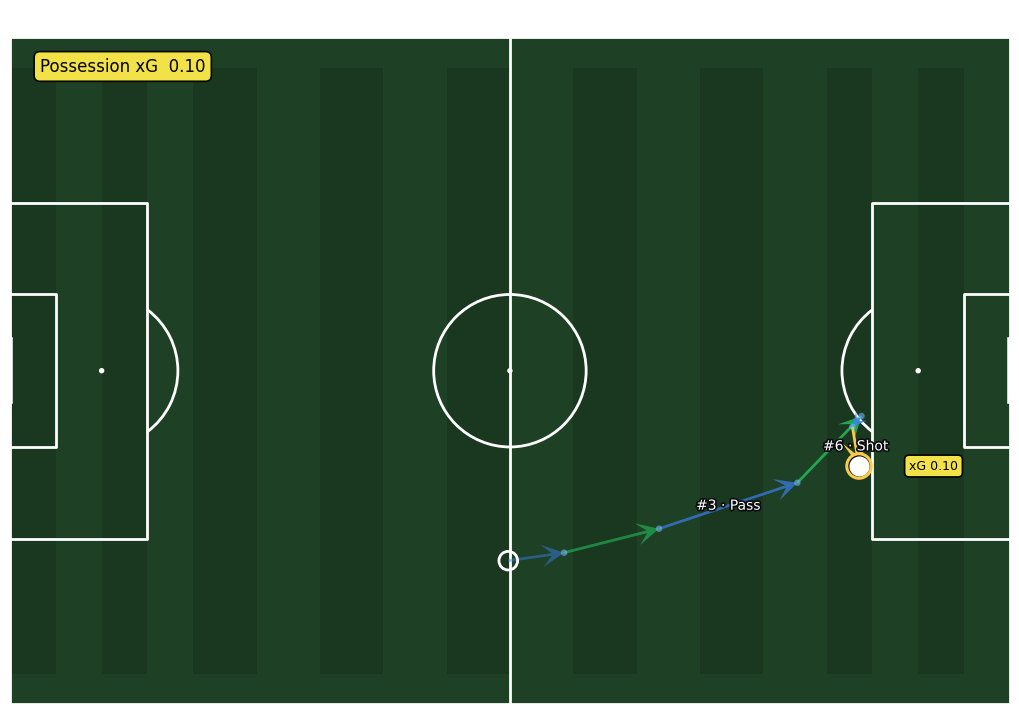

Random nice: match=3879781, poss=99.0, pred_xg=0.08


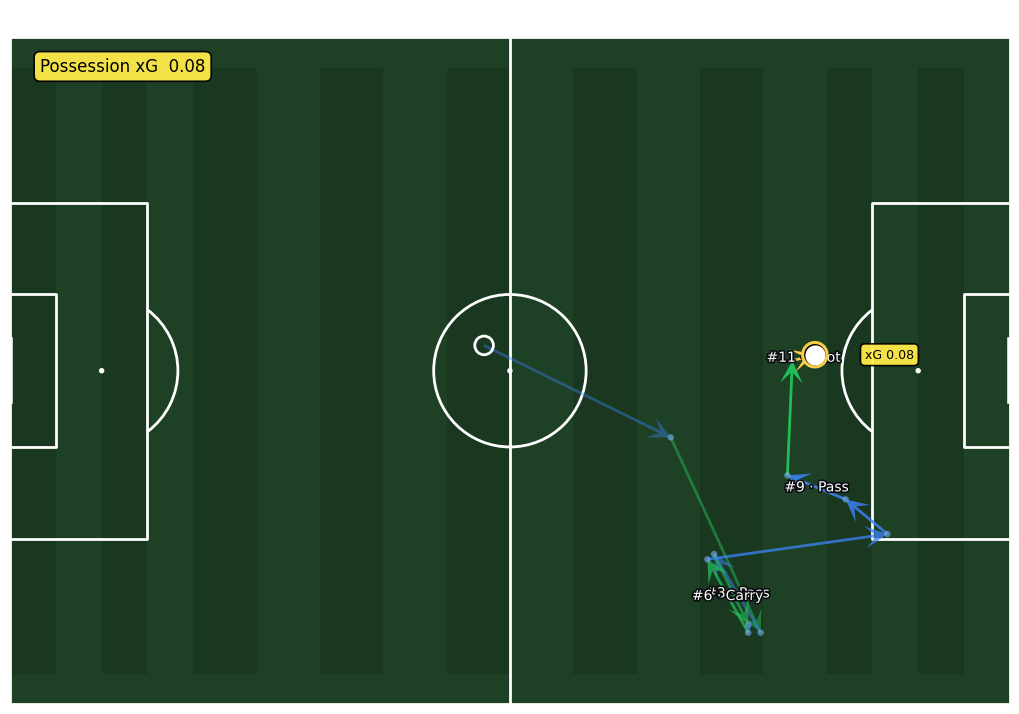

Longest on-ball: match=3754082, poss=128.0, pred_xg=-0.00


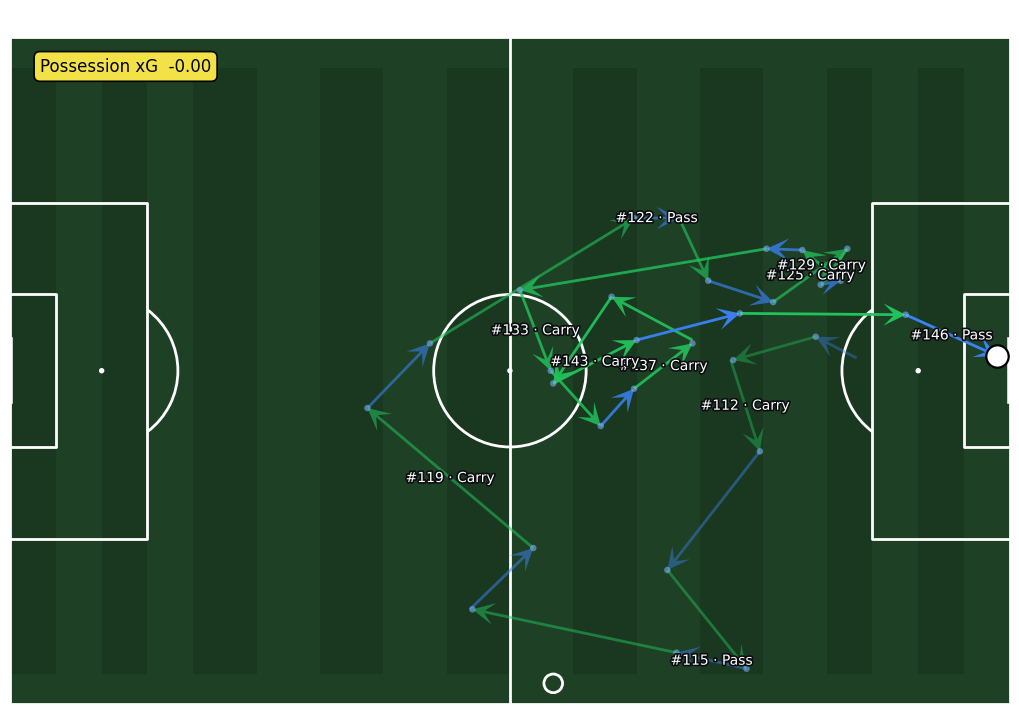

Highest pred xG: match=3754320, poss=109.0, pred_xg=1.16


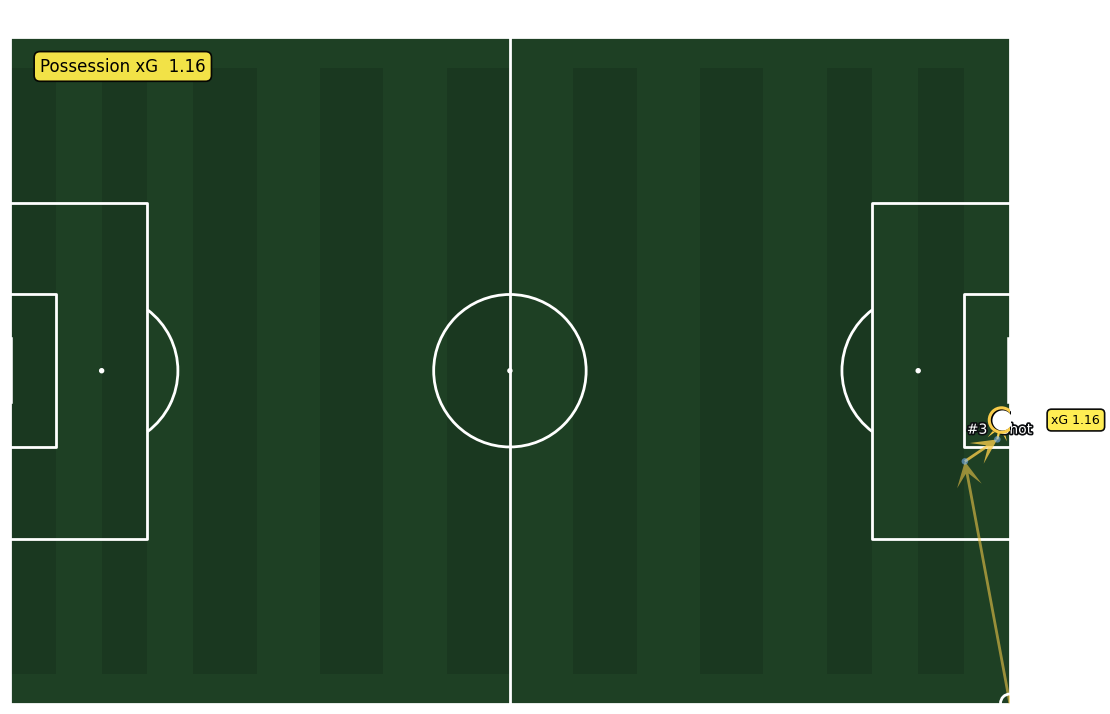

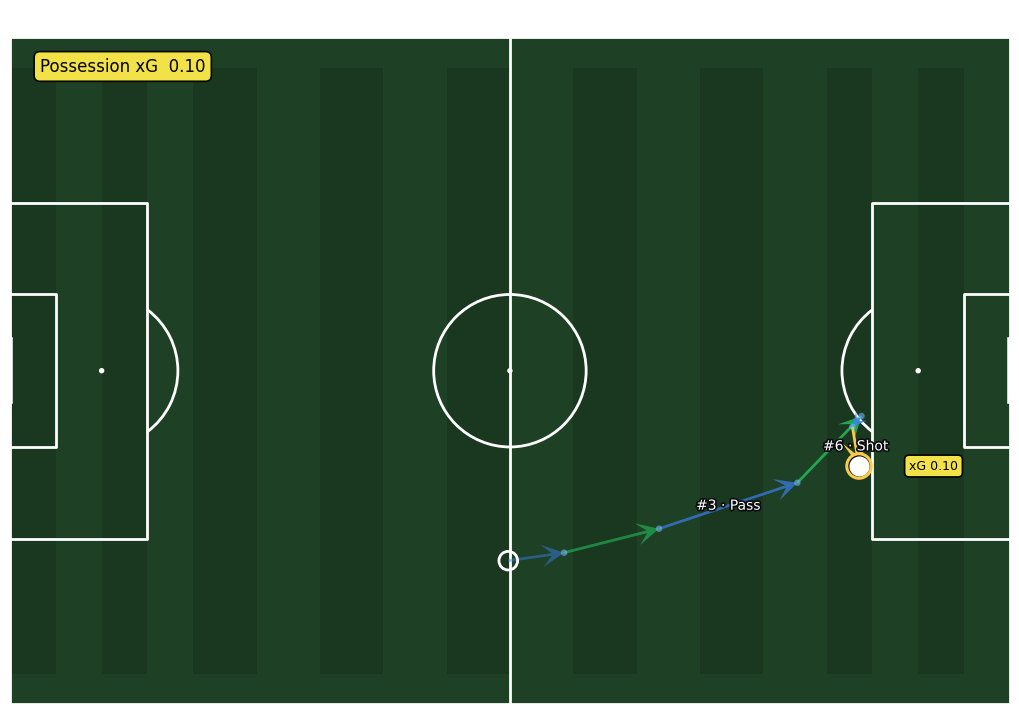

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mplsoccer import Pitch

# ---------- helpers ----------
def debug_chain(events_df, mid, pid, poss_col=None):
    poss_col = poss_col or ("possession" if "possession" in events_df.columns else "possession_id")
    s = events_df[(events_df.match_id==mid) & (events_df[poss_col]==pid)].reset_index(drop=True)
    evcol = "event" if "event" in s.columns else ("type" if "type" in s.columns else None)
    for i,row in s.iterrows():
        ex = pd.to_numeric(row.get("end_x"), errors="coerce")
        ey = pd.to_numeric(row.get("end_y"), errors="coerce")
        print(i, str(row.get(evcol))[:16], "->", (row.x,row.y), "→", (ex,ey))

def _safe_num(v, d=0.0):
    try:
        x = float(pd.to_numeric(v, errors='coerce'))
        return x if np.isfinite(x) else d
    except Exception:
        return d


def _ensure_endpoints(seq, x='x', y='y', ex='end_x', ey='end_y'):
    seq = seq.copy()
    if ex not in seq.columns: seq[ex] = np.nan
    if ey not in seq.columns: seq[ey] = np.nan
    for i in range(len(seq)):
        if pd.isna(seq.loc[i, ex]) or pd.isna(seq.loc[i, ey]):
            if i+1 < len(seq):
                seq.loc[i, ex] = seq.loc[i+1, x]
                seq.loc[i, ey] = seq.loc[i+1, y]
            else:
                seq.loc[i, ex] = seq.loc[i, x]
                seq.loc[i, ey] = seq.loc[i, y]
    return seq

def _scale_factor(series, target):
    """Return a multiplicative factor to map this series to target (120 or 80)."""
    s = pd.to_numeric(series, errors="coerce")
    m = float(np.nanmax(s.values)) if len(s) else np.nan
    if not np.isfinite(m):
        return 1.0
    if m <= 1.05:     # 0..1
        return target / 1.0
    if m <= 100.5:    # 0..100
        return target / 100.0
    return 1.0        # already ~target (e.g., 120 or 80)

# --- uses your existing helpers: _events_for_possession, _ensure_endpoints, _detect_scale ---

def _events_for_possession(df, match_id, poss_id):
    poss_col = "possession" if "possession" in df.columns else "possession_id"
    seq = df[(df["match_id"] == match_id) & (df[poss_col] == poss_id)].copy()
    if {"minute","second"}.issubset(seq.columns):
        seq["abs_t"] = pd.to_numeric(seq["minute"], errors="coerce").fillna(0)*60 + \
                       pd.to_numeric(seq["second"], errors="coerce").fillna(0)
        seq = seq.sort_values("abs_t")
    else:
        seq = seq.sort_index()
    return seq.reset_index(drop=True)


def plot_possession_chainview(events_df, match_id, poss_id, pred_xg=None, only_onball=True, annotate=True,
            view='full', pad=8, min_hop=None,
            *,                      # keyword-only from here
            fade=True,              # newer steps more opaque
            label_every=2,          # label every Nth step (and always last)
            max_steps=None,         # cap number of segments to draw
            mark_start=True,        # ring first event
            save_path=None
            ):
    
    """
    Draw a possession as a chained sequence: point_i → point_{i+1}, with the
    final shot (if present) ending at its shot end_x/end_y.
    """

    # 1) load + optional on-ball filter
    seq = _events_for_possession(events_df, match_id, poss_id)
    if seq.empty:
        raise ValueError("No events for that possession.")

    # strict on-ball whitelist to avoid 'dribbled past' etc.
    evcol = "event" if "event" in seq.columns else ("type" if "type" in seq.columns else None)
    if only_onball and evcol is not None:
        name = seq[evcol].astype(str).str.lower().str.strip()
        keep_names = {"pass", "carry", "dribble", "cross", "shot"}
        seq = seq[name.isin(keep_names)].reset_index(drop=True)
    if len(seq) < 1:
        raise ValueError("No on-ball events after filtering.")

    # 2) per-axis scaling to 120×80 (robust to mixed units per column)
    L, W = 120.0, 80.0
    fx  = _scale_factor(seq["x"], L)
    fy  = _scale_factor(seq["y"], W)
    fex = _scale_factor(seq.get("end_x", seq["x"]), L)
    fey = _scale_factor(seq.get("end_y", seq["y"]), W)

    xs = pd.to_numeric(seq["x"], errors="coerce") * fx
    ys = pd.to_numeric(seq["y"], errors="coerce") * fy

    # Safer on-ball filter (do this earlier if you prefer)
    if evcol is not None:
        name = seq[evcol].astype(str).str.lower().str.strip()
        # allow only true on-ball actions (exclude 'dribbled past', pressures, etc.)
        onball_keep = name.str.fullmatch(r"(pass|carry|dribble|cross|shot)")
        seq = seq[onball_keep].reset_index(drop=True)
        xs, ys = xs[onball_keep].reset_index(drop=True), ys[onball_keep].reset_index(drop=True)

    if len(seq) < 1:
        raise ValueError("No on-ball events after filtering.")

    # 3) CHAINED segments: start_i -> start_{i+1}   (no end_x/end_y here)
    if len(seq) < 2:
        x1 = xs.to_numpy()[:0]; y1 = ys.to_numpy()[:0]
        x2 = xs.to_numpy()[:0]; y2 = ys.to_numpy()[:0]
    else:
        x1 = xs.to_numpy()[:-1]
        y1 = ys.to_numpy()[:-1]
        x2 = xs.to_numpy()[1:]
        y2 = ys.to_numpy()[1:]

    # Shot info
    name = (seq[evcol].astype(str).str.lower().str.strip() if evcol else pd.Series([], dtype=str))
    shot_idx = np.where(name.str.contains(r"^shot$", regex=True))[0]
    shot_idx = int(shot_idx[-1]) if len(shot_idx) else -1

    # Optional shot end (for a thin gold "ball flight" only, not for chaining)
    ex = pd.to_numeric(seq.get("end_x"), errors="coerce") * fex if "end_x" in seq.columns else pd.Series(index=seq.index, dtype=float)
    ey = pd.to_numeric(seq.get("end_y"), errors="coerce") * fey if "end_y" in seq.columns else pd.Series(index=seq.index, dtype=float)
    def _valid_xy(a, b): 
        return np.isfinite(a) and np.isfinite(b) and (0 <= a <= L) and (0 <= b <= W)

    # 4) optional hop filter (on segments)
    seg_keep = np.ones_like(x1, dtype=bool)
    if min_hop is not None and len(x1) > 0:
        hop = np.hypot(x2 - x1, y2 - y1)
        seg_keep = hop >= float(min_hop)
        if not seg_keep.any(): seg_keep[:] = True

    x1, y1, x2, y2 = x1[seg_keep], y1[seg_keep], x2[seg_keep], y2[seg_keep]
    seg_end_idx = np.arange(1, len(seq))        # segments end at events 1..N-1
    seg_end_idx = seg_end_idx[seg_keep]

    # 4b) optional cap on number of segments (keep tail)
    if max_steps is not None and len(seg_end_idx) > max_steps:
        x1, y1, x2, y2 = x1[-max_steps:], y1[-max_steps:], x2[-max_steps:], y2[-max_steps:]
        seg_end_idx = seg_end_idx[-max_steps:]

    # 5) decide orientation (attack → right) robustly
    # Prefer the shot end; otherwise use net dx across segments
    # 5) decide orientation (attack → right)
    orient_x = None
    if shot_idx >= 1 and (shot_idx-1) in (seg_end_idx-1):
        shot_seg = list(seg_end_idx-1).index(shot_idx-1)
        orient_x = x2[shot_seg]

    net_dx = np.nanmedian(x2 - x1) if len(x2) else 0.0
    do_flip = (orient_x is not None and orient_x < L/2) or (orient_x is None and net_dx < 0)

    if do_flip:
        x1, x2 = L - x1, L - x2
        xs = L - xs

    # 6) xG vector (possession xG on last shot, else last event)
    if "xg" in seq.columns:
        xg = pd.to_numeric(seq["xg"], errors="coerce").fillna(0).to_numpy()
    else:
        xg = np.zeros(len(seq), dtype=float)
        tgt = shot_idx if (0 <= shot_idx < len(seq)) else (len(seq)-1)
        if pred_xg is not None and tgt >= 0:
            xg[tgt] = float(pred_xg)
    cum_xg = float(np.nansum(xg))
    # --- REPLACE TO HERE ---------------------------------------------------

    # 6b) Optional: refine flip using xG-weighted net progression (now xg exists)
    if orient_x is None and len(x1):
        w = np.clip([xg[j] for j in seg_end_idx], 0, 1) + 0.05  # small floor
        wdx = np.average((x2 - x1), weights=w)
        should_flip = (wdx < 0)
        if should_flip != do_flip:
            # re-flip consistently
            x1, x2 = L - x1, L - x2
            xs = L - xs
            do_flip = should_flip

    # keep everything on the pitch
    x1 = np.clip(x1, 0, L); x2 = np.clip(x2, 0, L)
    y1 = np.clip(y1, 0, W); y2 = np.clip(y2, 0, W)

    # 7) draw pitch
    pitch = Pitch(pitch_type='custom', pitch_length=L, pitch_width=W,
                  pitch_color='#1e4024', line_color='white',
                  stripe=True, stripe_color='#1a3820', stripe_zorder=0.2, line_zorder=2)
    fig, ax = pitch.draw(figsize=(11,7))

    # view window
    if view == 'half' and orient_x is not None:
        right_half = orient_x >= L/2
        ax.set_xlim(L/2 - pad if right_half else 0, L if right_half else L/2 + pad)
        ax.set_ylim(0, W)
    elif view == 'auto' and len(x2) > 0:
        xx = np.r_[x1, x2]
        yy = np.r_[y1, y2]   # <- was y2.values before (wrong if numpy)
        ax.set_xlim(max(0, xx.min()-pad), min(L, xx.max()+pad))
        ax.set_ylim(max(0, yy.min()-pad), min(W, yy.max()+pad))

    else:  # 'full'
        ax.set_xlim(0, L); ax.set_ylim(0, W)

    # 8) styled arrows + labels
    def style(t):
        t = (t or '').lower()
        if 'shot' in t:                 return dict(c='#f8cc4a', lw=3.0, a=1.0, head=9)
        if 'carry' in t or 'dribble' in t:  return dict(c='#22c55e', lw=2.6, a=.98, head=8)
        return dict(c='#3b82f6', lw=2.6, a=.98, head=8)

    nseg = len(seg_end_idx)
    for k, (xa, ya, xb, yb, j) in enumerate(zip(x1, y1, x2, y2, seg_end_idx), start=1):
        etxt = str(seq.iloc[j][evcol]) if evcol else 'event'
        st = style(etxt)
        alpha = (0.35 + 0.65 * (k / nseg)) if fade else st['a']
        pitch.arrows(xa, ya, xb, yb, ax=ax,
                     color=st['c'], lw=st['lw'], alpha=alpha,
                     width=2.0, headwidth=st['head'], headlength=st['head'], zorder=4)
        if annotate and (k % label_every == 0 or k == nseg):
            mx, my = (xa+xb)/2, (ya+yb)/2
            ax.text(mx, my, f'#{j} · {etxt}', fontsize=10, color='white',
                    ha='center', va='center', zorder=6,
                    path_effects=[pe.withStroke(linewidth=2.4, foreground='#0b0d10')])

    # 9) endpoints: scatter at segment ends; ring the shot location
    # map event-level xg sizes to segment ends by taking xg at 'j'
    # endpoints scatter (size by xG at the segment end event)
    sizes = 22 + 260*np.sqrt(np.clip([xg[j] for j in seg_end_idx], 0, 1))
    pitch.scatter(x2, y2, s=sizes if len(sizes) else 40, c='#7fb9ff',
                ax=ax, zorder=5, alpha=0.55, edgecolors='none')

    # --- E) ball marker & xG badge at shot end (or last end) ---
    if shot_idx >= 1 and (shot_idx - 1) in (seg_end_idx - 1):
        shot_seg = list(seg_end_idx - 1).index(shot_idx - 1)
        bx, by = x2[shot_seg], y2[shot_seg]
    elif len(x2) > 0:
        bx, by = x2[-1], y2[-1]
    else:
        bx = by = None

    if bx is not None:
        ax.scatter(bx, by, s=260, fc='white', ec='black', lw=1.6, zorder=8)
        if shot_idx >= 0:
            ax.scatter(bx, by, s=310, fc='none', ec='#f8cc4a', lw=2.2, zorder=9)
            ax.text(bx + 6, by, f'xG {cum_xg:.2f}', color='black', fontsize=9,
                    va='center', ha='left', zorder=9,
                    bbox=dict(boxstyle='round,pad=0.35', fc='#ffec4a', ec='black', lw=1.2, alpha=.95))
    # --- end E ---

    # optional start ring
    if mark_start and len(xs) > 0:
        ax.scatter(xs.iloc[0], ys.iloc[0], s=180, facecolors='none',
                edgecolors='white', linewidths=2, zorder=7)


    # title + possession xG badge
    ax.text(0.03, 0.97, f'Possession xG  {cum_xg:.2f}',
            transform=ax.transAxes, ha='left', va='top', fontsize=12, color='black',
            bbox=dict(boxstyle='round,pad=0.35', fc='#ffec4a', ec='black', lw=1.2, alpha=.95),
            zorder=10)
    ax.set_title(f"Match {match_id} • Possession {poss_id}  |  steps: {len(seq)}",
                fontsize=13, color='white', loc='left', pad=10)

    fig.tight_layout(pad=0.2)

    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

    return seq


# ---- Cell A: build meta once (re-run if you change poss/events/model) ----
def build_poss_meta(poss_df, events_df, model, X, Y):
    # fit (idempotent if already fit)
    model.fit(X, Y)

    # predict xG for each possession (use whatever features you actually have)
    feat_cols = [c for c in [
        "n_events","n_shots","prog_dist","net_prog","start_x","start_y","end_x","end_y","duration_s"
    ] if c in poss_df.columns]
    meta = poss_df.copy()
    meta["pred_xg"] = model.predict(meta[feat_cols]) if feat_cols else 0.0

    # name + on-ball
    poss_col = "possession" if "possession" in poss_df.columns else "possession_id"
    ev = events_df.copy()
    ev["name"] = (ev["event"] if "event" in ev.columns else ev["type"]).astype(str).str.lower()
    ev["onball"] = ev["name"].str.contains(r"pass|carry|dribble|cross|shot", regex=True)

    onball = ev.groupby(["match_id", poss_col])["onball"].sum().rename("onball_n").reset_index()
    steps  = ev.groupby(["match_id", poss_col]).size().rename("steps_all").reset_index()
    shots  = ev[ev["name"].str.contains("shot")].groupby(["match_id", poss_col]).size().rename("n_shots_ev").reset_index()
    crosses= ev[ev["name"].str.contains("cross")].groupby(["match_id", poss_col]).size().rename("n_cross").reset_index()

    meta = (meta
            .merge(onball, on=["match_id", poss_col], how="left")
            .merge(steps,  on=["match_id", poss_col], how="left")
            .merge(shots,  on=["match_id", poss_col], how="left")
            .merge(crosses,on=["match_id", poss_col], how="left"))
    meta[["onball_n","steps_all","n_shots_ev","n_cross"]] = (
        meta[["onball_n","steps_all","n_shots_ev","n_cross"]].fillna(0).astype(int)
    )
    return meta, poss_col

meta, POSSCOL = build_poss_meta(poss, events, pipe_tree, X, Y)

# ---- Cell B: pick several different “types” to demo ----
import numpy as np
rng = np.random.default_rng()

def pick_possessions(meta, poss_col, k_random=1):
    picks = []

    # A) Random “nice” (enough on-ball + some xG)
    pool = meta[(meta["onball_n"] >= 6) & (meta["pred_xg"] >= 0.05)]
    if not pool.empty:
        for _ in range(k_random):
            r = pool.sample(1, random_state=int(rng.integers(0, 1_000_000))).iloc[0]
            picks.append({"label":"Random nice", "match_id":int(r["match_id"]), "poss_id":r[poss_col], "pred_xg":float(r["pred_xg"])})

    # B) Long chain (most on-ball)
    r = meta.sort_values("onball_n", ascending=False).iloc[0]
    picks.append({"label":"Longest on-ball", "match_id":int(r["match_id"]), "poss_id":r[poss_col], "pred_xg":float(r["pred_xg"])})

    # C) Highest predicted xG
    r = meta.sort_values("pred_xg", ascending=False).iloc[0]
    picks.append({"label":"Highest pred xG", "match_id":int(r["match_id"]), "poss_id":r[poss_col], "pred_xg":float(r["pred_xg"])})

    # D) Fast progressive (if you have duration_s & net_prog)
    if {"duration_s","net_prog"}.issubset(meta.columns):
        pool = meta[(meta["duration_s"] <= 15) & (meta["net_prog"] >= 30)]
        if not pool.empty:
            r = pool.sort_values("pred_xg", ascending=False).iloc[0]
            picks.append({"label":"Fast progressive", "match_id":int(r["match_id"]), "poss_id":r[poss_col], "pred_xg":float(r["pred_xg"])})

    # E) With a cross
    pool = meta[meta["n_cross"] > 0]
    if not pool.empty:
        r = pool.sort_values(["pred_xg","onball_n"], ascending=[False, False]).iloc[0]
        picks.append({"label":"Includes cross", "match_id":int(r["match_id"]), "poss_id":r[poss_col], "pred_xg":float(r["pred_xg"])})

    import pandas as pd
    return pd.DataFrame(picks)

picks = pick_possessions(meta, POSSCOL, k_random=2)


# ---- Cell C: thin wrapper to plot a row from `picks`/`meta` ----
def show_possession_row(row, **plot_kwargs):
    m = int(row["match_id"])
    pid = row["poss_id"]
    pxg = float(row.get("pred_xg", 0.0))
    print(f"{row.get('label','possession')}: match={m}, poss={pid}, pred_xg={pxg:.2f}")

    # defaults
    defaults = dict(
        view='full', pad=8, min_hop=0.5,
        fade=True, label_every=2, max_steps=24,
        mark_start=True
    )
    # let caller override
    defaults.update(plot_kwargs)

    plot_possession_chainview(
        events, m, pid, pred_xg=pxg,
        **defaults
    )

# Browse several types
for _, r in picks.iterrows():
    show_possession_row(r, view='full', min_hop=0.7, max_steps=30, label_every=3)


row = picks.iloc[0]                      # pick whichever row you want
m_id = int(row["match_id"])
p_id = row["poss_id"]
pxg  = float(row.get("pred_xg", 0.0))

seq = plot_possession_chainview(
    events, m_id, p_id, pred_xg=pxg,
    view='full', min_hop=0.7, label_every=3, max_steps=28,
    only_onball=True, annotate=True
)

